In [1]:
import os, sys, subprocess, glob, shutil, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread
import h5py
import gzip
import collections
import pysam   # optional, used if you want to parse BAM later

# plotting default
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

In [2]:
# 셀 1: 사용자가 바꿀 부분
fastq_folder = "data/pbmc_1k_v3_fastqs"   # R1/R2 fastq들이 있는 폴더 (예: data/fastq)
star_index_dir = "STAR_index"           # STAR index (생성되어 있으면 재사용)
cellranger_h5 = "data/pbmc_1k_v3_raw_feature_bc_matrix.h5"  # 기존 Cell Ranger h5 파일(있으면)
output_dir = "results_starsolo"         # 결과 저장 디렉토리
threads = 8                             # STAR에 쓸 쓰레드 수

# STAR solo parameters for 10x v3 (이 데이터 설명이 16+12, R1=28bp, R2=91bp이라 가정)
cb_len = 16
umi_len = 12
expect_cells = 1000
cell_ranger_detected_cells_num = 1222

os.makedirs(output_dir, exist_ok=True)
print("fastq_folder:", fastq_folder)
print("star_index_dir:", star_index_dir)
print("cellranger_h5:", cellranger_h5)
print("output_dir:", output_dir)


fastq_folder: data/pbmc_1k_v3_fastqs
star_index_dir: STAR_index
cellranger_h5: data/pbmc_1k_v3_raw_feature_bc_matrix.h5
output_dir: results_starsolo


In [3]:
import glob, gzip

# 모든 FASTQ 파일 찾기
fastq_files = sorted(glob.glob(f"{fastq_folder}/*.fastq.gz"))
print("총 FASTQ 파일 개수:", len(fastq_files))
print("\n".join(fastq_files[:10]))

# R1, R2 분리
r1_files = sorted([f for f in fastq_files if "_R1_" in f])
r2_files = sorted([f for f in fastq_files if "_R2_" in f])
print("\nR1 파일:", len(r1_files), "\n", "\n".join(r1_files))
print("\nR2 파일:", len(r2_files), "\n", "\n".join(r2_files))

# FASTQ 첫 read 살펴보기
with gzip.open(r1_files[0], "rt") as f:
    for _ in range(4):
        print(f.readline().strip())


총 FASTQ 파일 개수: 6
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz

R1 파일: 2 
 data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz

R2 파일: 2 
 data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
@A00228:279:HFWFVDMXX:1:1101:8486:1000 1:N:0:NCATTACT
NGTGATTAGCTGTACTCGTATGTAAGGT
+
#FFFFFFFFFFFFFFFFFFFFFFFFFFF


In [4]:
from collections import Counter

def parse_r1_read(seq, cb_len=16, umi_len=12):
    cb = seq[:cb_len]
    umi = seq[cb_len:cb_len+umi_len]
    return cb, umi

def read_all_r1_fastq(r1_files, max_reads=100000):
    counter = Counter()
    for r1 in r1_files:
        with gzip.open(r1, "rt") as f:
            while True:
                header = f.readline().strip()
                if not header: break
                seq = f.readline().strip()
                f.readline()
                f.readline()
                cb, umi = parse_r1_read(seq, cb_len, umi_len)
                counter[(cb, umi)] += 1
                if len(counter) > max_reads:
                    break
    return counter

barcode_umi_counts = read_all_r1_fastq(r1_files, max_reads=200000)
print("Unique (CB, UMI) pairs:", len(barcode_umi_counts))


Unique (CB, UMI) pairs: 200002


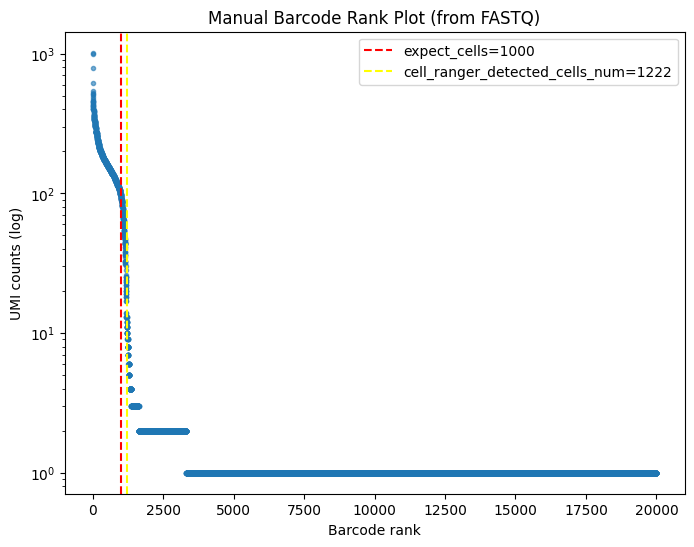

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_barcode_rank(barcode_umi_counts, top_n=20000):
    barcode_counts = {}
    for (cb, umi), c in barcode_umi_counts.items():
        barcode_counts[cb] = barcode_counts.get(cb, 0) + c
    
    sorted_counts = sorted(barcode_counts.values(), reverse=True)
    sorted_counts = sorted_counts[:top_n]

    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(sorted_counts)+1), sorted_counts, '.', alpha=0.6)
    plt.yscale("log")
    plt.xlabel("Barcode rank")
    plt.ylabel("UMI counts (log)")
    plt.title("Manual Barcode Rank Plot (from FASTQ)")
    plt.axvline(expect_cells, color="red", linestyle="--", label=f"expect_cells={expect_cells}")
    plt.axvline(cell_ranger_detected_cells_num, color="yellow", 
                linestyle="--", label=f"cell_ranger_detected_cells_num={cell_ranger_detected_cells_num}")
    
    plt.legend()
    plt.show()

plot_barcode_rank(barcode_umi_counts)


In [9]:
import subprocess

r1_str = ",".join(r1_files)
r2_str = ",".join(r2_files)

cmd = [
    "STAR",
    "--runThreadN", str(threads),
    "--genomeDir", star_index_dir,
    "--readFilesIn", r2_str, r1_str,  # STAR expects R2 first, then R1
    "--readFilesCommand", "zcat",
    "--soloType", "CB_UMI_Simple",
    "--soloCBstart", "1", "--soloCBlen", str(cb_len),
    "--soloUMIstart", str(cb_len+1), "--soloUMIlen", str(umi_len),
    "--soloCBwhitelist", "None",
    #"--soloCBwhitelist", "737K-august-2016.txt",  # 10x v3 whitelist
    "--outFileNamePrefix", f"{output_dir}/"
]

print("실행할 명령어:\n", " ".join(cmd))

실행할 명령어:
 STAR --runThreadN 8 --genomeDir STAR_index --readFilesIn data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz,data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz,data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz --readFilesCommand zcat --soloType CB_UMI_Simple --soloCBstart 1 --soloCBlen 16 --soloUMIstart 17 --soloUMIlen 12 --soloCBwhitelist None --outFileNamePrefix results_starsolo/


In [10]:
!STAR --version

2.7.10b


In [11]:
%%time
subprocess.run(cmd, check=True)

	STAR --runThreadN 8 --genomeDir STAR_index --readFilesIn data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz,data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz,data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz --readFilesCommand zcat --soloType CB_UMI_Simple --soloCBstart 1 --soloCBlen 16 --soloUMIstart 17 --soloUMIlen 12 --soloCBwhitelist None --outFileNamePrefix results_starsolo/
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Sep 23 14:57:27 ..... started STAR run
Sep 23 14:57:27 ..... loading genome



EXITING because of FATAL ERROR: could not open genome file STAR_index//genomeParameters.txt
SOLUTION: check that the path to genome files, specified in --genomeDir is correct and the files are present, and have user read permsissions

Sep 23 14:57:27 ...... FATAL ERROR, exiting


CalledProcessError: Command '['STAR', '--runThreadN', '8', '--genomeDir', 'STAR_index', '--readFilesIn', 'data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz,data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz', 'data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz,data/pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz', '--readFilesCommand', 'zcat', '--soloType', 'CB_UMI_Simple', '--soloCBstart', '1', '--soloCBlen', '16', '--soloUMIstart', '17', '--soloUMIlen', '12', '--soloCBwhitelist', 'None', '--outFileNamePrefix', 'results_starsolo/']' returned non-zero exit status 105.